# Disaster Tweets Classification using DL Word Embeddings

## Loading Libraries

In [60]:
import pandas as pd
import numpy as np

import re
import string
import os

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

# scikit-learn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import LinearSVC

plt.style.use('ggplot')

# tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Dropout
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam

In [ ]:
!pip install git+https://github.com/troyhunterz/preprocess_tr.git
!pip install textblob
!python -m spacy download en_core_web_lg

## Loading Data

In [2]:
tweet = pd.read_csv('dataset/data.csv')

## Exploring Data

In [3]:
print(f'rows: {tweet.shape[0]}\ncolumns:{tweet.shape[1]}')
tweet.sample(5) # 1 - disaster | 0 - non-disaster

rows: 7613
columns:5


,id,keyword,location,text,target
4708,6694,landslide,"i got 1/13 menpa replies, omg",*nominates self but @_ohhsehuns wins by a land...,0
6929,9938,trouble,on twitter,why is it trouble@niallhariss / @simply_vain l...,0
3733,5305,fear,Halifax,The number of people denying climate change on...,0
7203,10318,weapon,NaN,Even if u have your weapon and your badge we g...,1
4889,6961,massacre,NaN,@KabarMesir @badr58 \nNever dies a big Crime l...,1


In [4]:
tweet.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


## Exploratory Data Analysis

In [5]:
plt.rcParams['figure.figsize'] = [10,5]
plt.rcParams['figure.dpi'] = 90

### Target Class Distribution

In [6]:
tweet

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


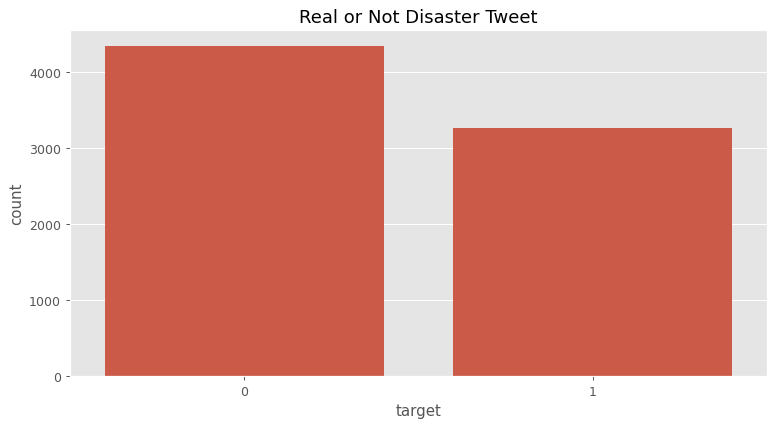

In [7]:
sns.countplot(tweet, x='target')
plt.title('Real or Not Disaster Tweet');

In [8]:
tweet['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

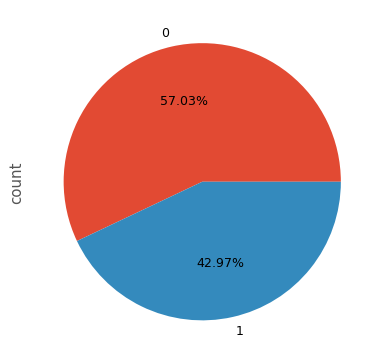

In [9]:
tweet['target'].value_counts().plot.pie(autopct='%1.2f%%');

## Numbers or Characters Distribution in Tweets

In [11]:
import preprocess_tr as ps

In [12]:
def digit_counts(x):
    digits = re.findall(r'[0-9,.]+', x)
    return len(digits)

In [13]:
def get_basic_features(df):
    if type(df) == pd.core.frame.DataFrame:
        df['char_counts'] = df['text'].apply(lambda x: ps.char_count(x))
        df['word_counts'] = df['text'].apply(lambda x: ps.word_count(x))
        df['avg_wordlength'] = df['text'].apply(lambda x: ps.avg_word_len(x))
        df['stopwords_counts'] = df['text'].apply(lambda x: ps.stopwords_count(x))
        df['hastag_counts'] = df['text'].apply(lambda x: ps.hashtags_count(x))
        df['mentions_counts'] = df['text'].apply(lambda x: ps.mentions_count(x))
        df['digit_counts'] = df['text'].apply(lambda x: digit_counts(x))
        df['uppercase_counts'] = df['text'].apply(lambda x: ps.uppers_count(x))
    else:
        print('ERROR: This function takes only Pandas DataFrame')
    
    return df

In [14]:
tweet = get_basic_features(tweet)
tweet.head(3)

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hastag_counts,mentions_counts,digit_counts,uppercase_counts
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,57,13,4.384615,8,1,0,0,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,32,7,4.571429,0,0,0,1,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,112,22,5.090909,11,0,0,1,0


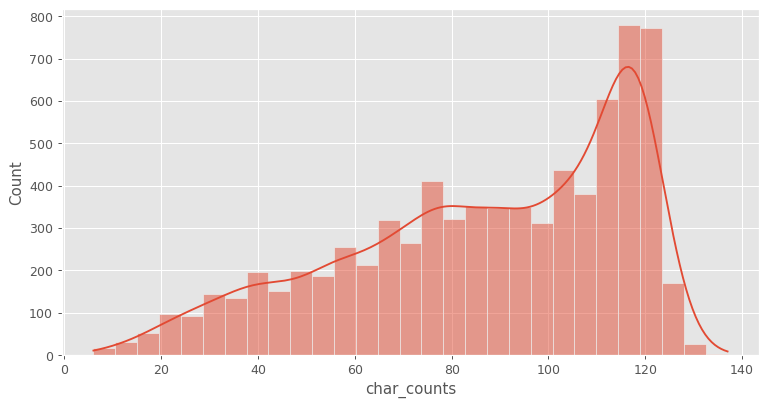

In [15]:
sns.histplot(tweet['char_counts'], kde=True); # 140 max

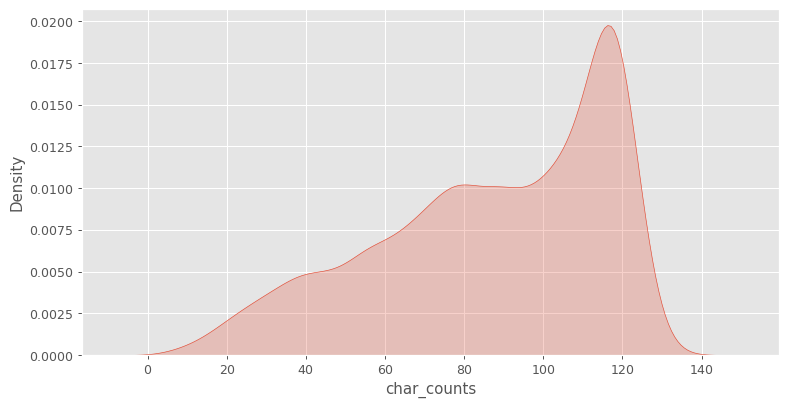

In [16]:
sns.kdeplot(tweet['char_counts'], fill=True);

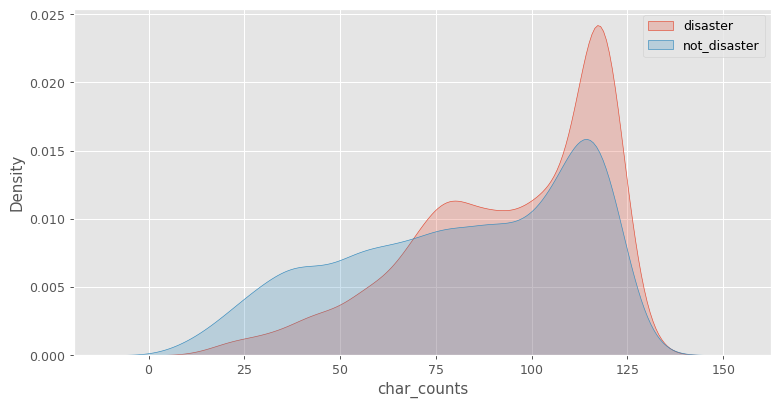

In [17]:
sns.kdeplot(tweet[tweet['target']==1]['char_counts'], fill=True, label='disaster')
sns.kdeplot(tweet[tweet['target']==0]['char_counts'], fill=True, label='not_disaster')
plt.legend();

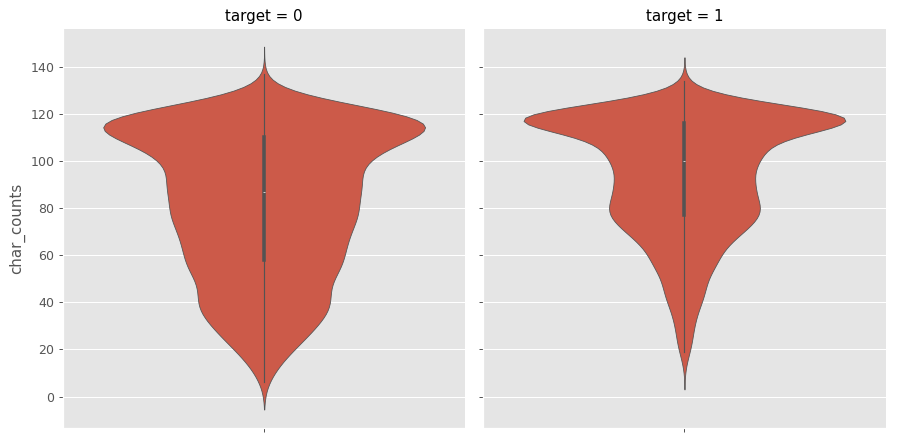

In [18]:
sns.catplot(y='char_counts', data=tweet, kind='violin', col='target');

### Numbers of Words, Average Words Length and Stop Words Distribution in Tweets

In [19]:
tweet.head(4)

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hastag_counts,mentions_counts,digit_counts,uppercase_counts
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,57,13,4.384615,8,1,0,0,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,32,7,4.571429,0,0,0,1,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,112,22,5.090909,11,0,0,1,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,57,8,7.125000,1,1,0,1,0


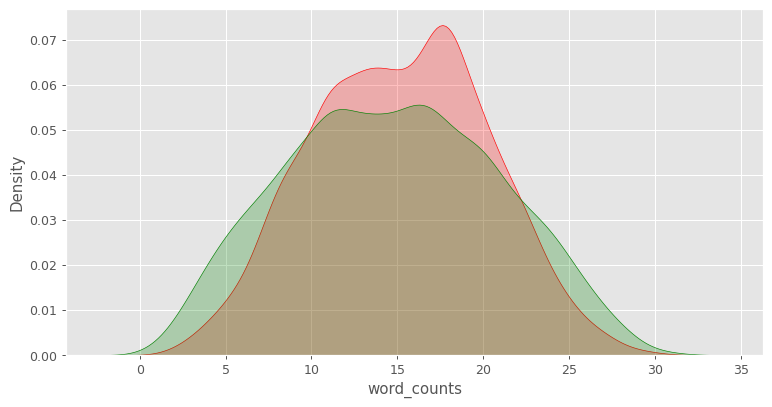

In [20]:
sns.kdeplot(tweet[tweet['target']==1]['word_counts'], fill=True, color='red')
sns.kdeplot(tweet[tweet['target']==0]['word_counts'], fill=True, color='green');

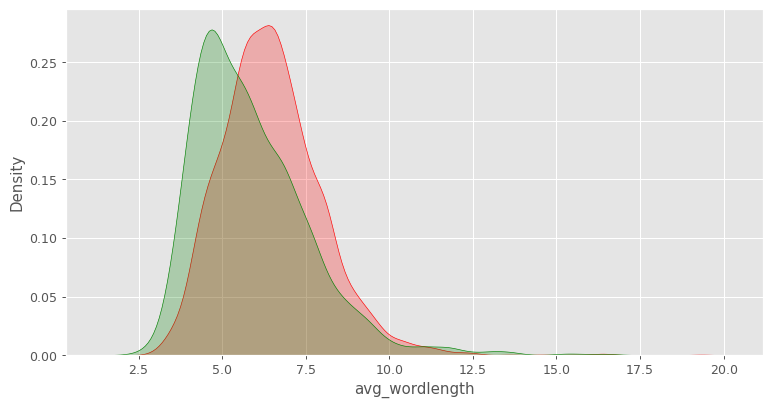

In [21]:
sns.kdeplot(tweet[tweet['target']==1]['avg_wordlength'], fill=True, color='red')
sns.kdeplot(tweet[tweet['target']==0]['avg_wordlength'], fill=True, color='green');

<Axes: xlabel='stopwords_counts', ylabel='Density'>

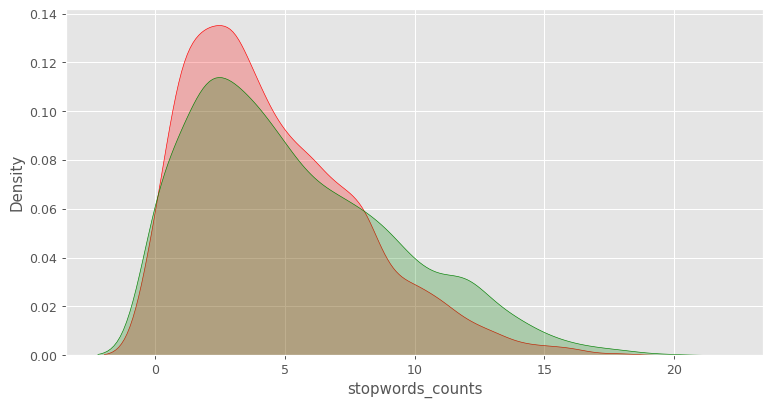

In [22]:
sns.kdeplot(tweet[tweet['target']==1]['stopwords_counts'], fill=True, color='red')
sns.kdeplot(tweet[tweet['target']==0]['stopwords_counts'], fill=True, color='green')

### Most and Least Common Words

In [23]:
def word_freq(df, col):
    text = ' '.join(df[col])
    text = text.split()
    freq = pd.Series(text).value_counts()
    return freq

In [24]:
freqs = word_freq(tweet, 'text')
top10 = freqs[:20]

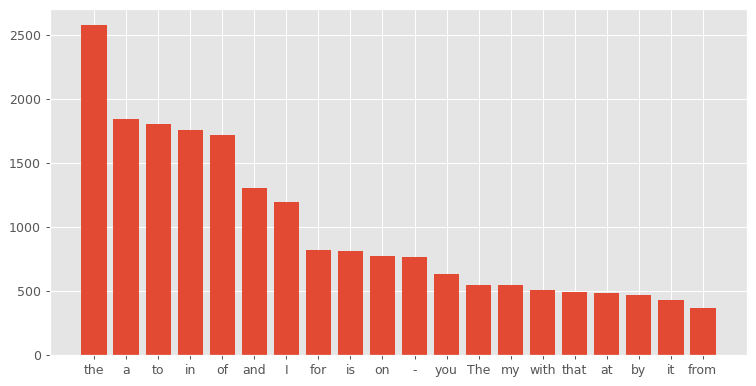

In [25]:
plt.bar(top10.index, top10.values);

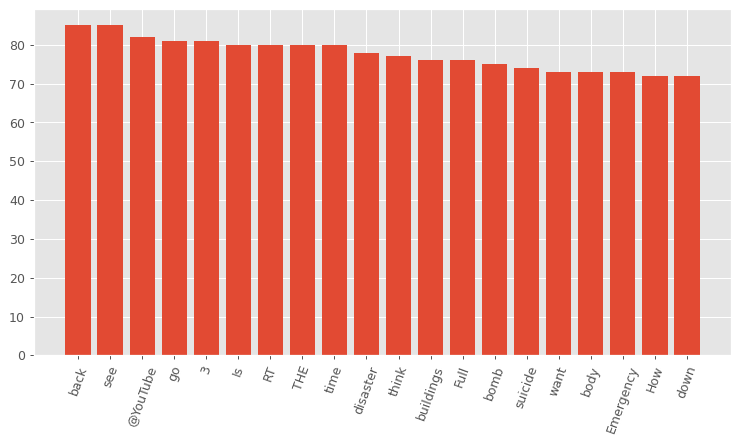

In [26]:
top = freqs[100:120]
plt.bar(top.index, top.values)
plt.xticks(rotation=70);

In [27]:
leasts20 = freqs[-20:]
leasts20

http://t.co/JD7rIK7fX0     1
ft.åÊM.O.P.                1
http://t.co/ZDTz3RbS6w     1
'Detonate.'                1
@ApolloBrown's             1
PLAY                       1
missed.                    1
detonate&amp;Shots         1
succeed                    1
marines                    1
@BBCTalkback               1
@rfcgeom66                 1
@tomfromireland            1
@SourMashNumber7           1
#FIYA!                     1
https://t.co/NlJVP3Vfyz    1
(Ft.                       1
Dix                        1
bandolier                  1
http://t.co/YmY4rSkQ3d     1
Name: count, dtype: int64

In [28]:
def get_ngram(df, col, ngram_range):
    vectorizer = CountVectorizer(ngram_range=(ngram_range, ngram_range))
    vectorizer.fit_transform(df[col])
    ngram = vectorizer.vocabulary_
    ngram = sorted(ngram.items(), key=lambda x: x[1], reverse=True)

    return ngram

In [29]:
bigram = get_ngram(tweet, 'text', ngram_range=2)
bigram[:4]

[('ûówe work', 68495),
 ('ûótech business', 68494),
 ('ûónegligence and', 68493),
 ('ûókody vine', 68492)]

## Data Cleaning

In [30]:
def dups_char(x):
    x = re.sub('(.)\\1{2,}', '\\1', x)
    return x

In [31]:
def clean_data(x):
    x = str(x).lower().replace('\\',' ').replace('_', ' ').replace('.', ' ')
    x = ps.contraction_to_expansion(x)
    x = ps.remove_emails(x)
    x = ps.remove_urls(x)
    x = ps.rm_html(x)
    x = ps.rm_accented_chars(x)
    x = ps.rm_special_chars(x)
    x = dups_char(x)
    return x

In [32]:

tweet['text'] = tweet['text'].apply(lambda x: clean_data(x))

c:\Users\rootm\anaconda3\Lib\site-packages\preprocess_tr\text_preprocess.py:113: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(text, 'lxml').get_text()


In [33]:
tweet.head(5)['text']

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3    130 people receive wildfires evacuation orders...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

## Disaster Words Visualization with Word Cloud

In [34]:
real_dis = word_freq(tweet[tweet['target']==1], 'text')
real_dis = ' '.join(real_dis.index)
real_dis

'the in a of to and is on for i at by from it that with not you this after fire are was as have my news over up more via disaster were an be people california suicide no has police who when but been killed like do 2 will hiroshima just storm so fires than crash out families we train about now into emergency s buildings bomb your there all mh370 they attack what two nuclear video wildfire am accident get bombing one how northern burning me dead new legionnaires bomber some homes if still car war atomic obama fatal he years us off collapse forest may watch debris malaysia 1 japan first latest or mass man severe city near water today had earthquake those confirmed found retweet would oil home 70 floods under warning spill world down army prime derailment minister injured could weather 4 3 outbreak evacuation wreckage 40 thunderstorm saudi migrants its being our old can flood missing flooding during investigators say bridge back their state death u rescuers suspect mosque her island charge

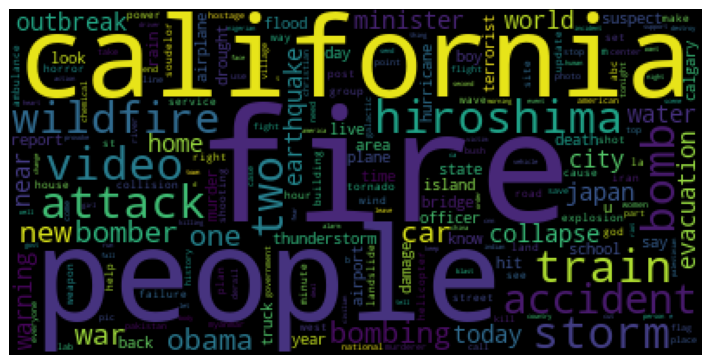

In [35]:
word_cloud = WordCloud(max_font_size=90).generate(real_dis)
plt.imshow(word_cloud)
plt.axis('off');

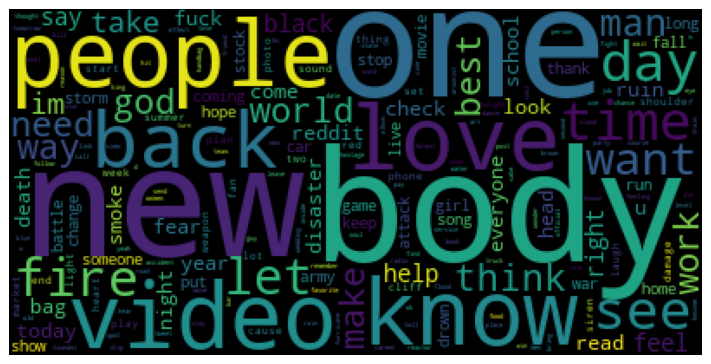

In [36]:
nreal_dis = word_freq(tweet[tweet['target']==0], 'text')
nreal_dis = ' '.join(nreal_dis.index)

word_cloud = WordCloud(max_font_size=90).generate(nreal_dis)
plt.imshow(word_cloud)
plt.axis('off');

## Classification with TFIDF and SVM

In [37]:
text = tweet['text']
y = tweet['target']

tfidf = TfidfVectorizer()

X = tfidf.fit_transform(text)

In [38]:
X, X.shape

(<7613x22357 sparse matrix of type '<class 'numpy.float64'>'
 	with 103450 stored elements in Compressed Sparse Row format>,
 (7613, 22357))

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [40]:
def run_svm(clf, X_train, X_test, y_train, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

In [41]:
%%time
clf = LinearSVC(dual=True)
run_svm(clf, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.79      0.89      0.84       869
           1       0.82      0.69      0.75       654

    accuracy                           0.80      1523
   macro avg       0.81      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523

[[773  96]
 [205 449]]
CPU times: total: 15.6 ms
Wall time: 21 ms


## Prediction on Test Data

In [42]:
def get_predict(x):
    x = clean_data(x)
    predict = clf.predict(tfidf.transform([x]))
    if predict[0] == 1:
        print(x, '--->>> [disaster]')
    elif predict[0] == 0:
        print(x, '--->>> [not_disaster]')

In [43]:
get_predict('there is fire in the forest'), get_predict('happy birthday'), get_predict('goverment has recently started regitration for covid-19 vaccine'), get_predict('trump threatned with nuclear war');

there is fire in the forest --->>> [disaster]
happy birthday --->>> [not_disaster]
goverment has recently started regitration for covid19 vaccine --->>> [not_disaster]
trump threatned with nuclear war --->>> [disaster]


## Classification with `word2vec` and `SVM`

In [45]:
import spacy
import en_core_web_lg

nlp = en_core_web_lg.load()

In [46]:
def get_vec(x):
    doc = nlp(x)
    vec = doc.vector
    return vec

In [47]:
tweet['vec'] = tweet['text'].apply(lambda x: get_vec(x))
tweet.head(3)

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hastag_counts,mentions_counts,digit_counts,uppercase_counts,vec
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1,57,13,4.384615,8,1,0,0,1,"[-0.26623327, 0.05843069, -0.1404636, -0.05265..."
1,4,NaN,NaN,forest fire near la ronge sask canada,1,32,7,4.571429,0,0,0,1,0,"[-0.014817425, -0.09212343, -0.10716944, -0.33..."
2,5,NaN,NaN,all residents asked to shelter in place are be...,1,112,22,5.090909,11,0,0,1,0,"[0.0059339865, 0.016337818, -0.105279535, -0.0..."


In [48]:
X = tweet['vec'].to_numpy()
X = X.reshape(-1, 1)
X.shape

(7613, 1)

In [49]:
X = np.concatenate(np.concatenate(X, axis=0), axis=0).reshape(-1, 300)
X.shape

(7613, 300)

In [50]:
y = tweet['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [51]:
%%time
clf = LinearSVC(dual='auto')
run_svm(clf, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       869
           1       0.81      0.71      0.76       654

    accuracy                           0.80      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.80      0.80      1523

[[762 107]
 [190 464]]
CPU times: total: 375 ms
Wall time: 408 ms


## Word Embedding and Classification with DL

In [61]:
token = Tokenizer()
token.fit_on_texts(text)

vocab_size = len(token.word_index) + 1
vocab_size

22394

In [62]:
print(token.word_index)

{'the': 1, 'a': 2, 'in': 3, 'to': 4, 'of': 5, 'i': 6, 'and': 7, 'is': 8, 'you': 9, 'for': 10, 'on': 11, 'it': 12, 'my': 13, 'not': 14, 'that': 15, 'with': 16, 'at': 17, 'by': 18, 'this': 19, 'have': 20, 'are': 21, 'from': 22, 'be': 23, 'was': 24, 'do': 25, 'like': 26, 'as': 27, 'out': 28, 'so': 29, 'am': 30, 'me': 31, 'your': 32, 'but': 33, 'up': 34, 'just': 35, 'will': 36, 'has': 37, 'all': 38, 'no': 39, 'after': 40, 'fire': 41, 'an': 42, 'when': 43, 'if': 44, 'he': 45, 'we': 46, 'new': 47, 'get': 48, 'they': 49, 'now': 50, 'about': 51, 'via': 52, 'more': 53, 'people': 54, 'what': 55, 'or': 56, 'news': 57, 'how': 58, 'one': 59, 'been': 60, '2': 61, 'there': 62, 'over': 63, 'would': 64, 'who': 65, 'into': 66, 'were': 67, 'video': 68, 'can': 69, 'emergency': 70, 'disaster': 71, 'us': 72, 'police': 73, 'than': 74, 'off': 75, 'her': 76, 'some': 77, 'still': 78, 'his': 79, 'back': 80, 'body': 81, 'crash': 82, 'burning': 83, 'time': 84, 'know': 85, 'storm': 86, 'california': 87, '3': 88, 's

In [63]:
encoded_text = token.texts_to_sequences(text)
print(encoded_text)

[[108, 4535, 21, 1, 836, 5, 19, 242, 126, 1563, 4536, 72, 38], [182, 41, 221, 769, 6834, 6835, 1336], [38, 1691, 1441, 4, 2078, 3, 655, 21, 122, 6836, 18, 1692, 39, 418, 243, 56, 2078, 3, 655, 1337, 21, 1060], [2828, 54, 4537, 1338, 243, 1337, 3, 87], [35, 92, 1162, 19, 316, 22, 6837, 2079, 27, 257, 22, 1338, 6838, 66, 2, 183], [2829, 374, 87, 1564, 797, 837, 3, 636, 6839, 533, 4, 1113, 375, 41, 4538, 1338], [216, 71, 838, 282, 1163, 798, 244, 5, 1693, 3, 6840, 1004, 2364, 1565], [6, 30, 11, 222, 5, 1, 1869, 7, 6, 69, 100, 2, 41, 3, 1, 4539], [62, 8, 42, 70, 243, 1246, 50, 3, 1, 569, 839, 1, 708], [6, 30, 2365, 15, 1, 492, 8, 237, 4, 108, 340], [594, 54, 611, 22, 1, 274, 470, 29, 612], [840, 613, 2830, 8, 217, 2831, 3490, 656, 2, 657, 6, 197, 3, 613, 2830, 55, 30, 6, 303, 25, 55, 30, 6, 303, 25, 6841, 244], [2832, 244, 2080, 6842, 2830, 1339, 56, 1870, 614, 6, 20, 741, 3491], [216, 3, 4540, 919, 46, 1694, 4540], [230, 4, 183, 392, 11, 2366, 3, 4541, 123, 82, 356], [595, 34, 94], [6, 10

In [64]:
max_length = 40 # word_counts
X = pad_sequences(encoded_text, maxlen=max_length, padding='post')

In [65]:
X

array([[ 108, 4535,   21, ...,    0,    0,    0],
       [ 182,   41,  221, ...,    0,    0,    0],
       [  38, 1691, 1441, ...,    0,    0,    0],
       ...,
       [2729, 2314, 4527, ...,    0,    0,    0],
       [  73, 1098,   40, ...,    0,    0,    0],
       [   1,  201,   53, ...,    0,    0,    0]])

In [66]:
X.shape

(7613, 40)

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [68]:
vec_size = 100
model = Sequential()
model.add(Embedding(vocab_size, vec_size))

model.add(Conv1D(32, 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(.5))

model.add(Dense(16, activation='relu'))
model.add(GlobalMaxPooling1D())

model.add(Dense(1, activation='sigmoid'))

model.build(input_shape=(None, max_length))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 40, 100)        │     2,239,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 39, 32)         │         6,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 19, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 19, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 19, 32)         │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 19, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 19, 16)         │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 16)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,247,433 (8.57 MB)

 Trainable params: 2,247,433 (8.57 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
%%time
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5931 - loss: 0.6724 - val_accuracy: 0.7479 - val_loss: 0.5610
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7875 - loss: 0.4900 - val_accuracy: 0.8011 - val_loss: 0.4610
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8794 - loss: 0.3136 - val_accuracy: 0.7859 - val_loss: 0.4705
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9247 - loss: 0.2105 - val_accuracy: 0.7577 - val_loss: 0.5342
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9577 - loss: 0.1243 - val_accuracy: 0.7636 - val_loss: 0.6198
CPU times: total: 1min 8s
Wall time: 9.23 s


In [70]:
def get_encoded(x):
    x = clean_data(x)
    x = token.texts_to_sequences([x])
    x = pad_sequences(x, maxlen=max_length, padding='post')
    return x

In [83]:
vec = get_encoded('i love fruits')
vec

array([[   6,  109, 4542,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0]])

In [85]:
def get_results(text):
    vec = get_encoded(text)
    pred = model.predict(vec)
    pred_class = (pred>0.5).astype(int)
    if pred_class == 0:
        print(f'[not disaster] | {pred}')
    elif pred_class == 1:
        print(f'[disaster] | {pred}')

In [90]:
get_results('polina wants to play valorant')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[not disaster] | [[0.01706921]]
